In [129]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

import causalpy as cp

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def inv_logit(z):
    """Compute the inverse logit (sigmoid) of z."""
    return 1 / (1 + np.exp(-z))


def simulate_data(n=2500, alpha_true=3.0, rho=0.6, cate_estimation=False):
    # Exclusion restrictions:
    # X[0], X[1] affect both Y and T (confounders)
    # X[2], X[3] affect ONLY T (instruments for T)
    # X[4] affects ONLY Y (predictor of Y only)

    betaY = np.array(
        [0.5, -0.3, 0.0, 0.0, 0.4, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    )  # X[2], X[3] excluded
    betaD = np.array(
        [0.7, 0.1, -0.4, 0.3, 0.0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    )  # X[4] excluded
    p = len(betaY)

    # noise variances and correlation
    sigma_U = 3.0
    sigma_V = 3.0

    # design matrix (n × p) with mean-zero columns
    X = np.random.normal(size=(n, p))
    X = (X - X.mean(axis=0)) / X.std(axis=0)

    mean = [0, 0]
    cov = [[sigma_U**2, rho * sigma_U * sigma_V], [rho * sigma_U * sigma_V, sigma_V**2]]
    errors = np.random.multivariate_normal(mean, cov, size=n)
    U = errors[:, 0]  # error in outcome equation
    V = errors[:, 1]  #

    # continuous treatment
    T_cont = X @ betaD + V

    # latent variable for binary treatment
    T_latent = X @ betaD + V
    T_bin = np.random.binomial(n=1, p=inv_logit(T_latent), size=n)

    alpha_individual = 3.0 + 2.5 * X[:, 0]

    # outcomes
    Y_cont = alpha_true * T_cont + X @ betaY + U
    if cate_estimation:
        Y_bin = alpha_individual * T_bin + X @ betaY + U
    else:
        Y_bin = alpha_true * T_bin + X @ betaY + U

    # combine into DataFrame
    data = pd.DataFrame(
        {
            "Y_cont": Y_cont,
            "Y_bin": Y_bin,
            "T_cont": T_cont,
            "T_bin": T_bin,
        }
    )
    data["alpha"] = alpha_true + alpha_individual
    for j in range(p):
        data[f"feature_{j}"] = X[:, j]
    data["Y_cont_scaled"] = (data["Y_cont"] - data["Y_cont"].mean()) / data[
        "Y_cont"
    ].std(ddof=1)
    data["Y_bin_scaled"] = (data["Y_bin"] - data["Y_bin"].mean()) / data["Y_bin"].std(
        ddof=1
    )
    data["T_cont_scaled"] = (data["T_cont"] - data["T_cont"].mean()) / data[
        "T_cont"
    ].std(ddof=1)
    data["T_bin_scaled"] = (data["T_bin"] - data["T_bin"].mean()) / data["T_bin"].std(
        ddof=1
    )
    return data


data = simulate_data()
instruments_data = data.copy()
features = [col for col in data.columns if "feature" in col]
formula = "Y_cont ~ T_cont + " + " + ".join(features)
instruments_formula = "T_cont ~ 1 + " + " + ".join(features)
data

,Y_cont,Y_bin,T_cont,T_bin,alpha,feature_0,feature_1,feature_2,feature_3,feature_4,...,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,Y_cont_scaled,Y_bin_scaled,T_cont_scaled,T_bin_scaled
0,17.285021,5.560022,4.908333,1,4.221970,-0.711212,0.678770,0.807216,1.502488,-0.194990,...,-0.355420,1.402186,-1.517787,0.292296,-0.439312,-0.400863,1.478663,1.030321,1.535974,1.001401
1,-5.418737,-1.169369,-1.416456,0,3.571828,-0.971269,0.155694,0.094208,1.060349,0.918542,...,0.647043,0.978512,0.102692,-1.338446,1.164631,1.157542,-0.477164,-0.677874,-0.459080,-0.998202
2,8.329916,5.750195,1.859907,1,6.389524,0.155810,0.097990,1.886364,0.204515,1.407368,...,-0.789757,-1.376844,-1.164524,-0.854488,-0.563027,-1.762406,0.707221,1.078595,0.574396,1.001401
3,-14.109005,-3.260798,-3.616069,0,1.522008,-1.791197,-0.025364,-1.849614,-0.420513,-0.813558,...,-0.967529,0.604905,0.136397,0.087200,-0.575056,-0.244472,-1.225791,-1.208765,-1.152913,-0.998202
4,15.927794,6.070905,4.285630,1,8.262360,0.904944,-0.648125,-0.420076,0.774960,0.612525,...,2.362694,2.702110,-1.565191,1.689404,1.198610,0.117392,1.361744,1.160004,1.339552,1.001401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,-6.973181,-2.492475,-0.493568,1,6.399022,0.159609,2.004918,1.850936,-0.205821,1.826866,...,0.180511,-0.656888,-1.253321,1.057077,-0.803677,-0.759486,-0.611072,-1.013733,-0.167970,1.001401
2496,-7.457602,1.094568,-2.850723,0,9.043466,1.217386,-1.788360,-0.342299,-0.635556,0.595195,...,-0.020930,-0.459529,1.528013,0.135980,-0.448317,-0.113937,-0.652803,-0.103194,-0.911497,-0.998202
2497,-12.389506,-5.563091,-2.275472,0,2.631578,-1.347369,0.948935,0.733226,0.776689,1.007780,...,0.394645,-1.223821,-0.281657,-0.934772,-0.587933,1.399632,-1.077664,-1.793181,-0.730043,-0.998202
2498,4.181542,1.763852,1.805896,1,6.074689,0.029876,1.265076,-1.047612,-0.174857,-1.611537,...,0.660882,1.338977,-1.475265,-1.475989,0.910175,0.325985,0.349857,0.066698,0.557359,1.001401


### Hyperparameters for Variable Selection Priors

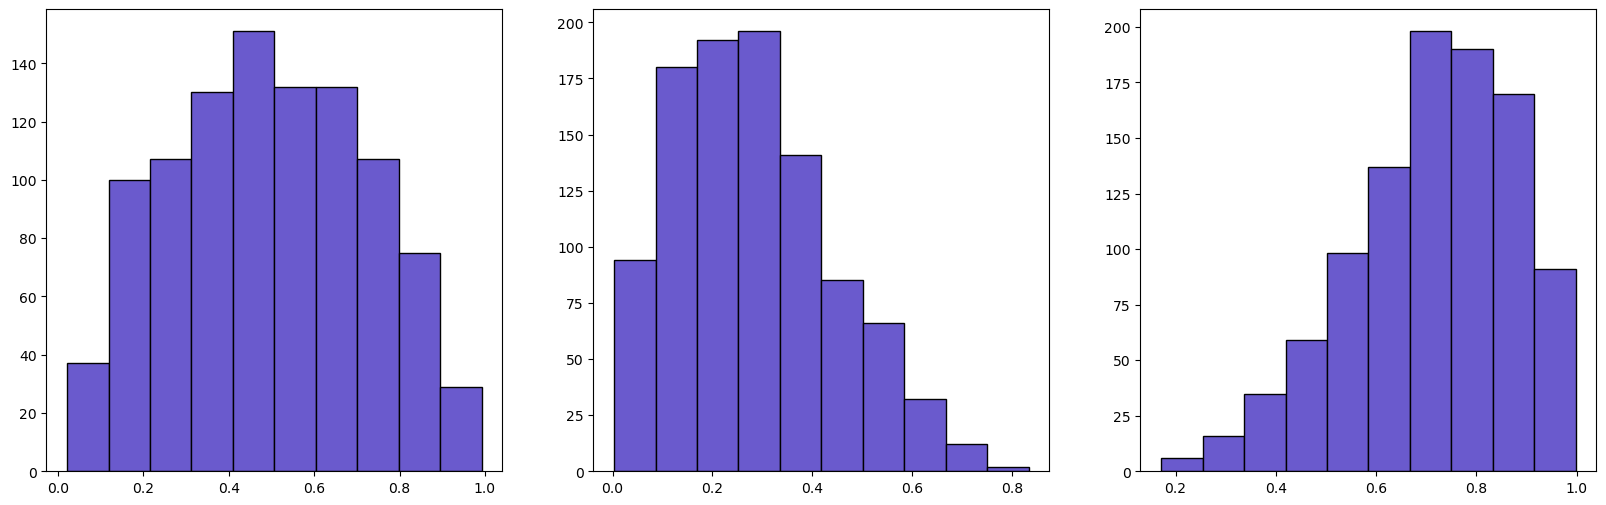

In [3]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
axs = axs.flatten()
axs[0].hist(pm.draw(pm.Beta.dist(2, 2), 1000), ec="black", color="slateblue")
axs[1].hist(pm.draw(pm.Beta.dist(2, 5), 1000), ec="black", color="slateblue")
axs[2].hist(pm.draw(pm.Beta.dist(5, 2), 1000), ec="black", color="slateblue");

In [5]:
sample_kwargs = {
    "draws": 1000,
    "tune": 2000,
    "chains": 2,
    "cores": 2,
    "target_accept": 0.95,
    "progressbar": True,
    "random_seed": 42,
    "mp_ctx": "spawn",
}

# =========================================================================
# Model 1: Normal priors (no selection)
# =========================================================================
print("\n" + "-" * 80)
print("Model 1: Normal Priors (No Variable Selection)")
print("-" * 80)

result_normal = cp.InstrumentalVariable(
    instruments_data=instruments_data,
    data=data,
    instruments_formula=instruments_formula,
    formula=formula,
    model=cp.pymc_models.InstrumentalVariableRegression(sample_kwargs=sample_kwargs),
    vs_prior_type=None,  # No variable selection
)

# =========================================================================
# Model 2: Spike-and-Slab priors
# =========================================================================
print("\n" + "-" * 80)
print("Model 2: Spike-and-Slab Priors")
print("-" * 80)

result_spike_slab = cp.InstrumentalVariable(
    instruments_data=instruments_data,
    data=data,
    instruments_formula=instruments_formula,
    formula=formula,
    model=cp.pymc_models.InstrumentalVariableRegression(sample_kwargs=sample_kwargs),
    vs_prior_type="spike_and_slab",
    vs_hyperparams={
        "pi_alpha": 2,
        "pi_beta": 2,
        "slab_sigma": 2,
    },
)


--------------------------------------------------------------------------------
Model 1: Normal Priors (No Variable Selection)
--------------------------------------------------------------------------------


/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/causalpy/experiments/instrumental_variable.py:187: UserWarning: Warning. The treatment variable is not Binary.
                This is not necessarily a problem but it violates
                the assumption of a simple IV experiment.
                The coefficients should be interpreted appropriately.
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_t, beta_z, chol_cov]
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Output()

/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pytensor/compile/function/types.py:1039: RuntimeWarning: invalid value encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 99 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/causalpy/experiments/instrumental_variable.py:187: UserWarning: Warning. The treatment variable is not Binary.
                This is not necessarily a problem but it violates
                the assumption of a simple IV experiment.
                The coefficients should be interpreted appropriately.
  warnings.warn(
/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/causalpy/pymc_models.py:699: UserWarning: Variable selection priors specified. The 'mus' and 'sigmas' in the priors dict will be ignored for 


--------------------------------------------------------------------------------
Model 2: Spike-and-Slab Priors
--------------------------------------------------------------------------------


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [pi_beta_t, beta_t_raw, gamma_beta_t_u, pi_beta_z, beta_z_raw, gamma_beta_z_u, chol_cov]
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Output()

/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pytensor/compile/function/types.py:1039: RuntimeWarning: invalid value encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)
/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pytensor/compile/function/types.py:1039: RuntimeWarning: invalid value encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 461 seconds.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


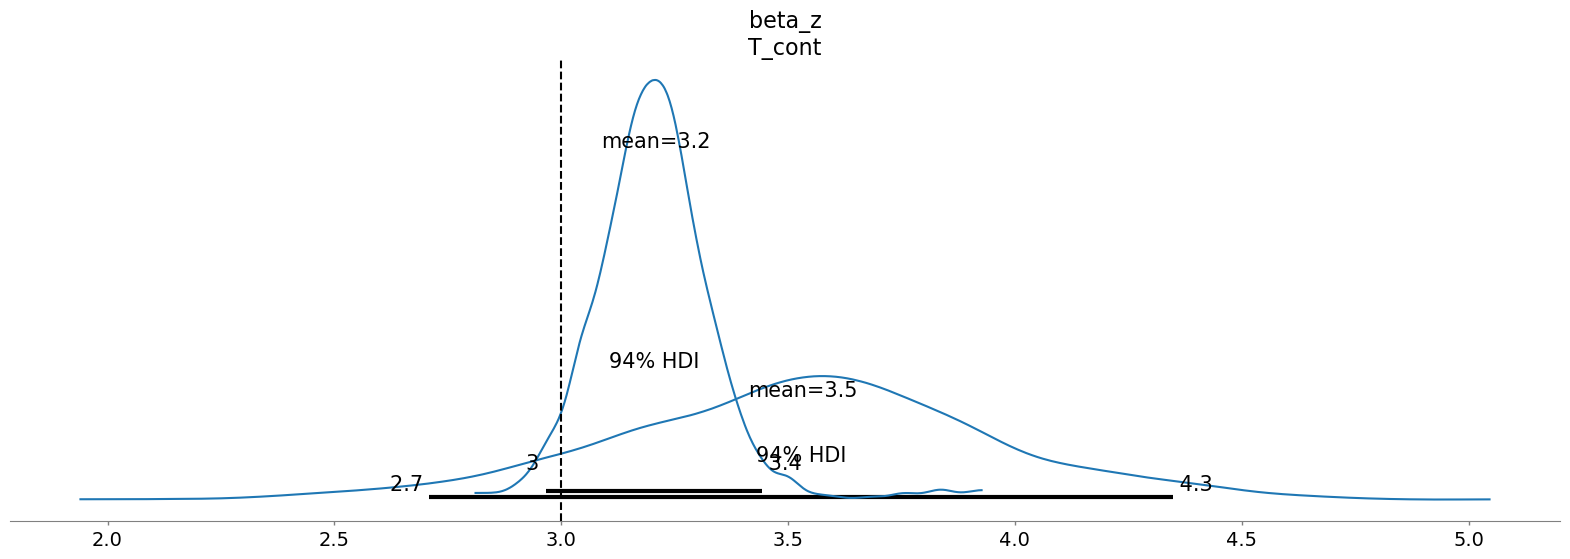

In [7]:
fig, ax = plt.subplots(figsize=(20, 6))
az.plot_posterior(
    result_normal.idata, var_names=["beta_z"], coords={"covariates": ["T_cont"]}, ax=ax
)
az.plot_posterior(
    result_spike_slab.idata,
    var_names=["beta_z"],
    coords={"covariates": ["T_cont"]},
    ax=ax,
)
ax.axvline(3, color="black", linestyle="--")

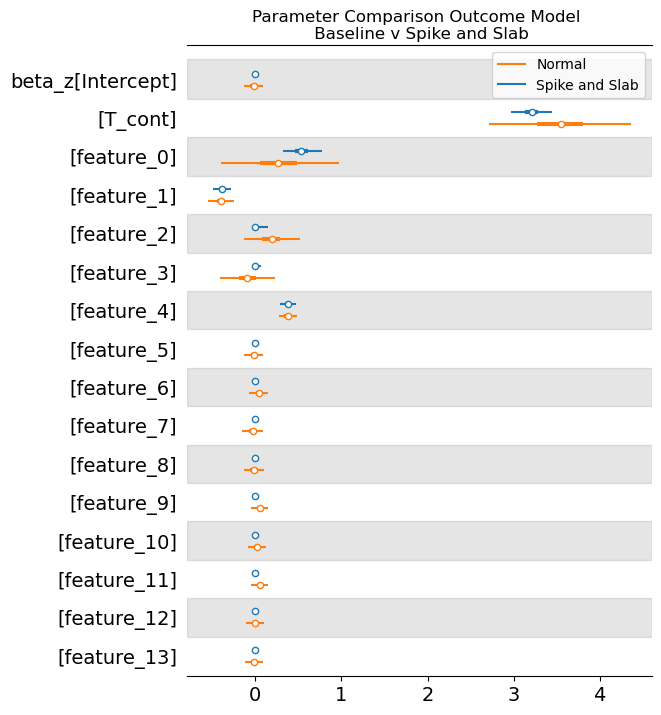

In [8]:
axs = az.plot_forest(
    [result_spike_slab.idata, result_normal.idata],
    var_names=["beta_z"],
    combined=True,
    model_names=["Spike and Slab", "Normal"],
)
axs[0].set_title("Parameter Comparison Outcome Model \n Baseline v Spike and Slab");

#### The Treatment Model

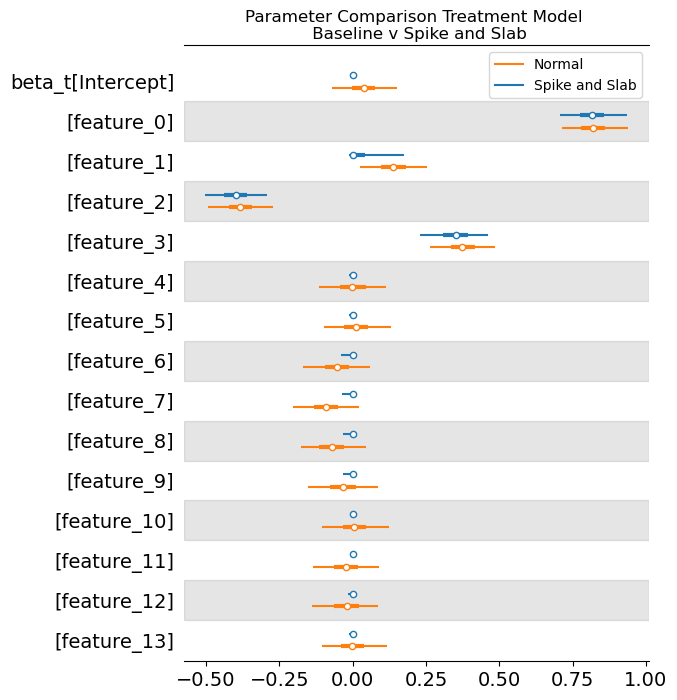

In [9]:
axs = az.plot_forest(
    [result_spike_slab.idata, result_normal.idata],
    var_names=["beta_t"],
    combined=True,
    model_names=["Spike and Slab", "Normal"],
)

axs[0].set_title("Parameter Comparison Treatment Model \n Baseline v Spike and Slab");

In [ ]:
summary = result_spike_slab.model.vs_prior_outcome.get_inclusion_probabilities(
    result_spike_slab.idata, "beta_z"
)
summary

,prob,selected,gamma_mean
0,0.0105,False,0.014042
1,1.0000,True,0.990424
2,0.7605,True,0.775804
3,0.6880,True,0.719690
4,0.0570,False,0.064343
5,0.0330,False,0.038359
6,0.6755,True,0.704165
7,0.0085,False,0.011460
8,0.0170,False,0.021624
9,0.0130,False,0.015590


## Horseshoe

In [72]:
# =========================================================================
# Model 2: Horseshoe priors
# =========================================================================
print("\n" + "-" * 80)
print("Model 3: Horseshoe Priors")
print("-" * 80)

result_horseshoe = cp.InstrumentalVariable(
    instruments_data=instruments_data,
    data=data,
    instruments_formula=instruments_formula,
    formula=formula,
    model=cp.pymc_models.InstrumentalVariableRegression(sample_kwargs=sample_kwargs),
    vs_prior_type="horseshoe",
)


--------------------------------------------------------------------------------
Model 3: Horseshoe Priors
--------------------------------------------------------------------------------


/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/causalpy/experiments/instrumental_variable.py:187: UserWarning: Warning. The treatment variable is not Binary.
                This is not necessarily a problem but it violates
                the assumption of a simple IV experiment.
                The coefficients should be interpreted appropriately.
  warnings.warn(
/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/causalpy/pymc_models.py:699: UserWarning: Variable selection priors specified. The 'mus' and 'sigmas' in the priors dict will be ignored for beta coefficients. Only 'eta' and 'lkj_sd' will be used.
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau_beta_t, lambda_beta_t, c2_beta_t, beta_t_raw, tau_beta_z, lambda_beta_z, c2_beta_z, beta_z_raw, chol_cov]
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info

Output()

/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pytensor/compile/function/types.py:1039: RuntimeWarning: invalid value encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)
/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pytensor/compile/function/types.py:1039: RuntimeWarning: invalid value encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 743 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [130]:
summary = result_horseshoe.model.vs_prior_outcome.get_shrinkage_factors(
    result_horseshoe.idata, "beta_z"
)
summary

,shrinkage_factor,lambda_tilde,tau
0,0.024168,1.163944,0.031037
1,1.574053,75.808614,0.031037
2,0.454083,21.869287,0.031037
3,0.416588,20.063451,0.031037
4,0.078152,3.763922,0.031037
5,0.043892,2.113912,0.031037
6,0.388261,18.699190,0.031037
7,0.027243,1.312060,0.031037
8,0.027663,1.332293,0.031037
9,0.026640,1.283037,0.031037


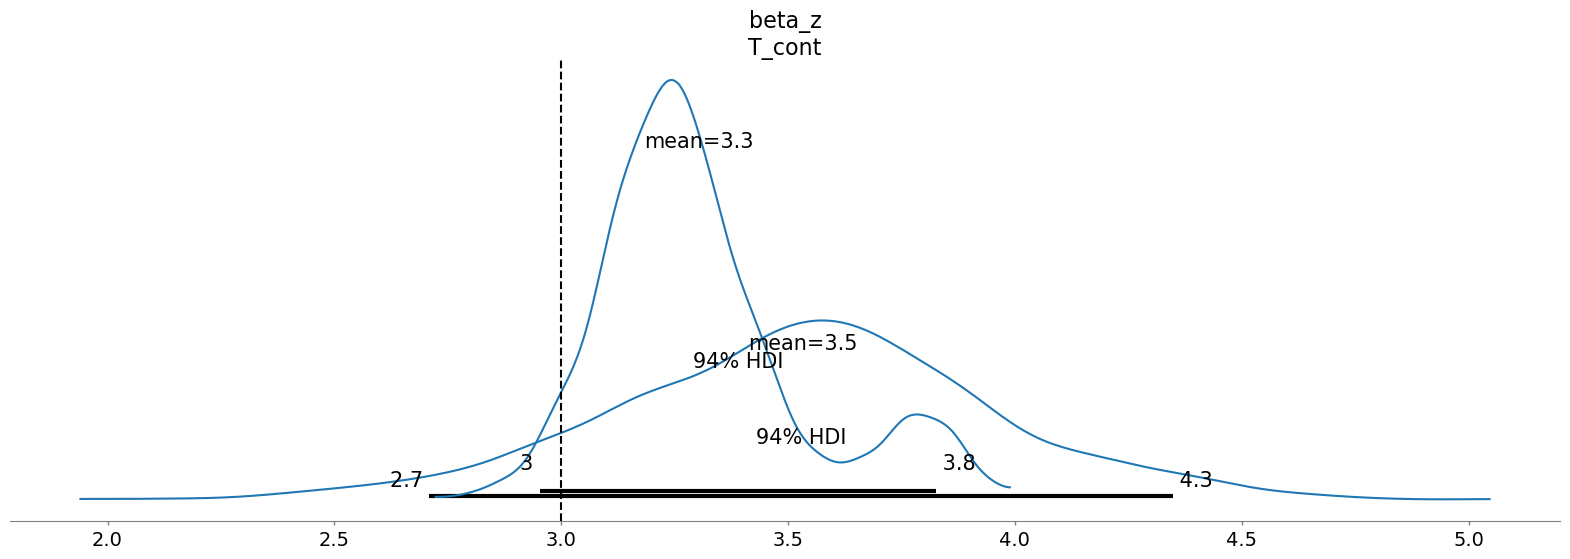

In [134]:
fig, ax = plt.subplots(figsize=(20, 6))
az.plot_posterior(
    result_normal.idata, var_names=["beta_z"], coords={"covariates": ["T_cont"]}, ax=ax
)
az.plot_posterior(
    result_horseshoe.idata,
    var_names=["beta_z"],
    coords={"covariates": ["T_cont"]},
    ax=ax,
)
ax.axvline(3, color="black", linestyle="--")